In [403]:
import numpy as np
from scipy.sparse import random
import matplotlib.pyplot as plot

In [404]:
V = 2 # number of features
R = 20 # size of reservoir
LEARN_TIME = 5
READOUT_TIME = 100
LEARNING_RATE = 0.001
DENSITY = 0.25
SCALING = 0.15

Wr = random(R, R, density=DENSITY).toarray() % 0.1
# Win = random(V, R, density=DENSITY).toarray()
Win = np.random.random((V, R))
W_readout = np.random.random((R, 1))

X = np.array([[0, 0, 1, 1], [0, 1, 0, 1]])
h = np.random.random((R, 1))
y = np.array([0, 0, 0, 1]) 
delta = []

In [405]:
def advance_state(activation_function):
    global h, x, Win, Wr, delta
    h_new = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
    h_new = activation_function(h_new)
    delta.append(np.sum(h_new - h))
    h = h_new

In [406]:
def relu(x):
    if x > 0:
	    return x
    else:
        return 0
    
def linear(x):
	return x

def sigmoid(x):
	return 1/(1 + np.exp(-x))

In [407]:
def forward(x):
	global Win, Wr, h
	predict = np.matmul(Win.transpose(), x) + np.matmul(Wr.transpose(), h)
	return np.matmul(W_readout.transpose(), predict)

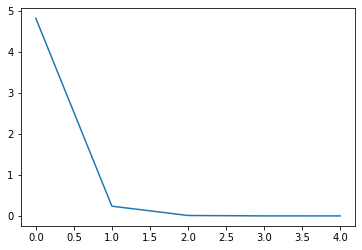

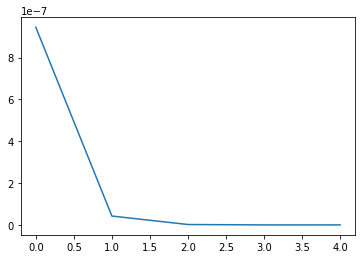

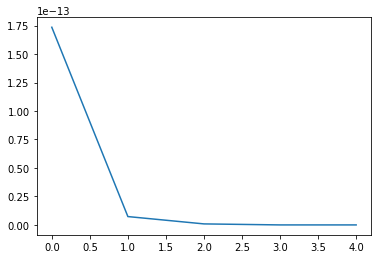

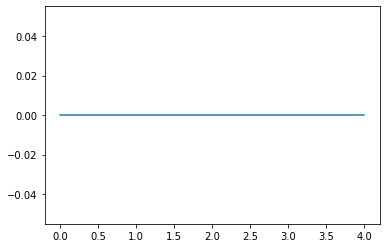

In [408]:
for datapoint in range(4):
	x = X[:, 3].reshape(2, 1)
	label = y[3]
	
	for iteration in range(LEARN_TIME):
	    advance_state(sigmoid)
	
	global delta
	fig, ax = plot.subplots()
	ax.plot(range(delta.__len__()), delta)
	delta = []
	
	for iteration in range(READOUT_TIME):
		predict = forward(x)
		W_readout = W_readout - LEARNING_RATE * (predict - label)

In [409]:
print(forward(X[:, 0].reshape(2,1)))
print(forward(X[:, 1].reshape(2,1)))
print(forward(X[:, 2].reshape(2,1)))
print(forward(X[:, 3].reshape(2,1)))


[[0.18483555]]
[[0.44205113]]
[[0.74323935]]
[[1.00045494]]
